# Exploring transformed data

This notebook explores and modifies data, after it has been transformed into a desired format.
The exploration will help understanding of the data, and allow for any further changes that will be required for good practice in machine learning.
Some parts of the exploration are saved for usage later, e.g. distribution statistics for normalization

### Intended outcomes

After exploring this notebook, the reader will be more comfortable in techniques that help understanding of data which will give more confidence in the task before performing machine learning

### Environment

This notebook is intended to be run in the py-lightning-cbh conda environment defined in requirements_torch.yml

In [1]:
# imports
import datetime

# file handling
import os
import pathlib
import sys
from tempfile import TemporaryDirectory

import dask
import dask.array

# training helpers
import mlflow.pytorch

# math operators
import numpy as np
import pytorch_lightning as pl

# ml
import torch
import zarr
from dask.diagnostics import CacheProfiler, Profiler, ResourceProfiler, visualize
from mlflow.tracking import MlflowClient
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import (
    RichProgressBar,
)  # this progress bar works through jupyterHub on spice
from pytorch_lightning.loggers import MLFlowLogger

# defined in directory (model related definitions)
import cbh_data_definitions
import cbh_torch_lstm
import cbh_torch_MLP

/home/h02/hsouth/.conda/envs/py-lightning-cbh/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("pl ver:", pl.__version__)
print("mlflow ver:", mlflow.__version__)
print("torch ver:", torch.__version__)
print("Python ver:", sys.version_info)

pl ver: 1.8.1
mlflow ver: 2.1.1
torch ver: 1.13.1
Python ver: sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)


In [3]:
# for during development, must be run in order to debug functions in imported files without a kernel restart
RELOAD_PACKAGES = False
if RELOAD_PACKAGES:
    
    import importlib
    
    importlib.reload(cbh_torch_lstm)
    importlib.reload(cbh_torch_MLP)
    importlib.reload(cbh_data_definitions)

In [7]:
root_data_directory = pathlib.Path(os.environ["DATADIR"]) / "cbh_data"

dev_data_path = root_data_directory / "analysis_ready" / "dev.zarr"
training_data_path = root_data_directory / "analysis_ready" / "train.zarr"

Load the data

In [8]:
(
    train_input,
    train_labels,
    _,
) = cbh_data_definitions.load_data_from_zarr(training_data_path)

(dev_input, dev_labels, _) = cbh_data_definitions.load_data_from_zarr(dev_data_path)

# the cloud volume is not needed for the task, so isn't saved on the load
# show a chunk, used to inform dask cache size
train_input

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 



dask.array<from-zarr, shape=(111820800, 70, 3), dtype=float32, chunksize=(465920, 70, 3), chunktype=numpy.ndarray>

Compute some data and display info about class for classification distribution. Since a compute() is required, left as a setting otherwise a later full compute will fail

ok
done

Model predictions binned: (Class label, Count): ((0, 24550245), (1, 1620213), (2, 1950361), (3, 2328333), (4, 2651219), (5, 2687883), (6, 2908108), (7, 3139639), (8, 3001463), (9, 2912899), (10, 2917489), (11, 2924491), (12, 2695919), (13, 2258395), (14, 1676634), (15, 1246818), (16, 987662), (17, 818199), (18, 744188), (19, 734406), (20, 735796), (21, 757895), (22, 796440), (23, 879240), (24, 1043614), (25, 1328484), (26, 1455795), (27, 905726), (28, 833602), (29, 833955), (30, 825888), (31, 805788), (32, 799099), (33, 801287), (34, 823831), (35, 870879), (36, 918939), (37, 982027), (38, 1044271), (39, 1055222), (40, 957745), (41, 851581), (42, 723140), (43, 559304), (44, 371778), (45, 181245), (46, 54507), (47, 17457), (48, 11935), (49, 4180), (50, 601), (51, 313), (52, 199), (53, 3), (69, 24834470)) 

Percentage of samples with cloud bases: 0.7779083140167125


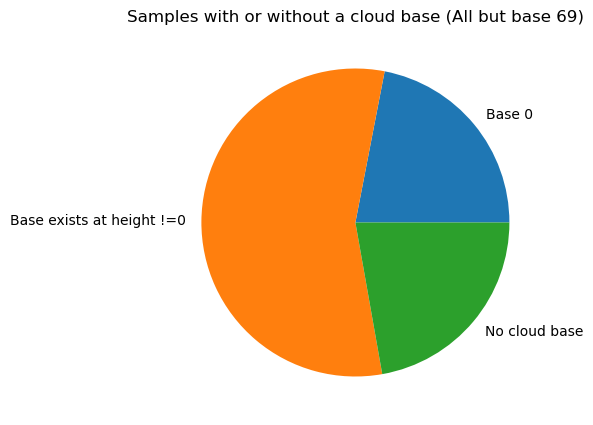

In [24]:
display_data_info = True
if display_data_info:
    import matplotlib.pyplot as plt

    labels, counts = np.unique(
        train_labels, return_counts=True
    )  # get the counts of samples for each cloud base height
    print("Computing labels")
    labels = labels.compute()
    print("Finished Compute")
    counts = counts.compute()
    bins_targ = tuple(zip(list(labels), list(counts)))
    print(
        "Percentage of samples with cloud bases:",
        np.sum(counts[0:-1]) / (np.sum(counts[-1]) + np.sum(counts[0:-1])),
    )  # find percentage of samples that were not mapped to height=69
    # fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    fig = plt.figure(figsize=(5,5))
    len_samples = len(train_labels)
    
    plt.pie([np.sum(counts[0:1]),np.sum(counts[1:-1]), np.sum(counts[-1])], labels=["Base 0", "Base exists at height !=0", "No cloud base"])
    plt.title("Samples with or without a cloud base (All but base 69)")
    plt.show()

In [ ]:
if display_data_info:
    print(
        "\nModel predictions binned: (Class label, Count):", bins_targ, "\n"
    )  # print the computed information

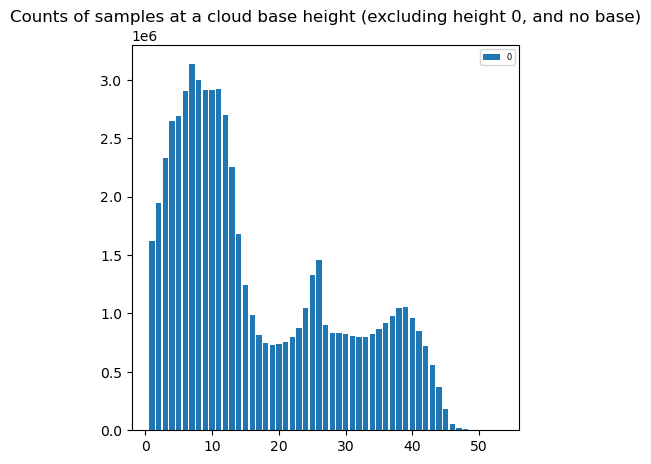

In [25]:
if display_data_info:
    plt.figure(figsize=(5,5))
    plt.bar(labels[1:-1], counts[1:-1])  # create pie chart
    plt.title("Counts of samples at a cloud base height in data (excluding height 0 and no-base)")
    plt.legend(labels, fontsize=6)

## Re-save data in random order

A lot of data exists for the task and compute is limited, for this reason it is unlikely in model development and tuning that more than 1 epoch of training through the data will be performed. In order to speed up the training and tuning, the data will be saved back in a pre-randomized order so that this computation and access of random parts of the data does not have to be done during model training.

In [56]:
RESAVE_DATA_AS_RANDOM = False

In [57]:
np.random.seed(42)
print("Start permutation gen")
p = np.random.permutation(len(train_input))
p_dev = np.random.permutation(len(dev_input))
print("End permutation gen")

Start permutation gen
End permutation gen


As in the previous notebook, the data is large and all would have to be in memory at once, for this reason the tasks are split up to prevent running out of memory

In [58]:
if RESAVE_DATA_AS_RANDOM:
    from dask.diagnostics import ProgressBar, ResourceProfiler

    # progressbar sits at 100% for a while thus time reporting is not correct
    with ProgressBar():
        train_input = train_input.compute()
    with ProgressBar():
        train_labels = train_labels.compute()

In [59]:
if RESAVE_DATA_AS_RANDOM:
    train_inputp = train_input[p]
    train_labelsp = train_labels[p]

In [60]:
if RESAVE_DATA_AS_RANDOM:
    train_input = train_inputp
    train_labels = train_labelsp

### calculate good chunksize - 4gb per chunk as random chunks come about for one chunk at a time strategy, 4gb is reasonable to store in majority of cases

87.48GB = 111820800 samples

373.24MB = 465920 samples

approx 1250000 samples per GB, so desire 5000000 sample chunksize

5000000 in not a factor of the len however, so choose closest factor - and it might be worth considering the length of the validation set too

closest factor of train set: 5324800
closest factor of dev: 307200 (all samples)

HOWEVER: the codec for chunk compression handles only a max of 2GB, so must go lower - max size turns out to be 2329600

In [61]:
if RESAVE_DATA_AS_RANDOM:
    print("train dev gcd:", np.gcd(len(train_input), len(dev_input)))
    print(
        "Factors of train: ",
        [n for n in range(1, len(train_input) + 1) if len(train_input) % n == 0],
    )
    print(
        "Factors of dev: ",
        [n for n in range(1, len(dev_input) + 1) if len(dev_input) % n == 0],
    )

Save the sample randomized arrays back to disk in a new zarr file

In [62]:
if RESAVE_DATA_AS_RANDOM:
    import zarr

    root_data_directory = pathlib.Path(os.environ["SCRATCH"]) / "cbh_data"

    path_to_save_zarr_train = (
        root_data_directory / "analysis_ready" / "train_randomized.zarr"
    )  # output for zarr files

    store = zarr.DirectoryStore(path_to_save_zarr_train)
    # define objected for arrays to be grouped under

    zarr_grouping = zarr.group(store=store, overwrite=True)

    # initialize and then write on zarr arrays for all desired arrays to be saved

    cloud_base_label_y = zarr_grouping.zeros(
        shape=train_labels.shape,
        dtype=train_labels.dtype,
        name="cloud_base_label_y.zarr",
        chunks=(2329600),
    )

    print("Start save 1")
    cloud_base_label_y[:] = train_labels
    print("End save 1")

    humidity_temp_pressure_x = zarr_grouping.zeros(
        shape=train_input.shape,
        dtype=train_input.dtype,
        name="humidity_temp_pressure_x.zarr",
        chunks=(2329600, 70, 3),
    )
    print("Start save 2")
    humidity_temp_pressure_x[:] = train_input
    print("End save 2")

In [63]:
if RESAVE_DATA_AS_RANDOM:
    del train_input
    del train_inputp
    del train_labelsp
    del train_labels
    dev_input = dev_input[p_dev].compute()
    dev_labels = dev_labels[p_dev].compute()

In [64]:
if RESAVE_DATA_AS_RANDOM:
    root_data_directory = pathlib.Path(os.environ["SCRATCH"]) / "cbh_data"

    path_to_save_zarr_train = (
        root_data_directory / "analysis_ready" / "dev_randomized.zarr"
    )  # output for zarr files

    store = zarr.DirectoryStore(path_to_save_zarr_train)
    # define objected for arrays to be grouped under

    zarr_grouping = zarr.group(store=store, overwrite=True)

    # initialize and then write on zarr arrays for all desired arrays to be saved

    cloud_base_label_y = zarr_grouping.zeros(
        shape=dev_labels.shape,
        dtype=dev_labels.dtype,
        name="cloud_base_label_y.zarr",
        chunks=(len(dev_labels)),
    )

    print("Start save 1")
    cloud_base_label_y[:] = dev_labels
    print("End save 1")

    humidity_temp_pressure_x = zarr_grouping.zeros(
        shape=dev_input.shape,
        dtype=dev_input.dtype,
        name="humidity_temp_pressure_x.zarr",
        chunks=(len(dev_input), 70, 3),
    )
    print("Start save 2")
    humidity_temp_pressure_x[:] = dev_input
    print("End save 2")

## Testing the output

Do some manual checking of the saved data to ensure the data behaves as we expect, e.g. the same indices of different arrays correspond to the same sample in from the cube

In [65]:
print(p[0:20])
import iris

cubes = iris.load(
    str(pathlib.Path(os.environ["SCRATCH"]) / "cbh_data" / "train" / "train_large.nc")
)
print(cubes)  # shorter comes first
inp_cube_humid = cubes[2]
tar_cube = cubes[1]
inp_cube_temp = cubes[4]

[ 35835418  55141703  54842272  54891720   8231197  71696864  14032326
  55779294   1322555  62093350  69540500  37845760  32668867  74008561
 106687661  70874472  32218412   4017705  92936491  13776806]


/var/tmp/ipykernel_17129/4057101540.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = iris.load(str('/scratch/hsouth/cbh_data/train/train_large.nc'))
/var/tmp/ipykernel_17129/4057101540.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = iris.load(str('/scratch/hsouth/cbh_data/train/train_large.nc'))
/var/tmp/ipykernel_17129/4057101540.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  cubes = iris.load(str('/scratch/hsouth/cbh_data/train/train_large.nc')

0: m01s05i250 / (unknown)              (time: 364; model_level_number: 70; latitude: 480; longitude: 640)
1: cloud_volume_fraction_in_atmosphere_layer / (1) (time: 364; model_level_number: 70; latitude: 480; longitude: 640)
2: specific_humidity / (unknown)       (time: 364; model_level_number: 70; latitude: 480; longitude: 640)
3: air_pressure / (Pa)                 (time: 364; model_level_number: 70; latitude: 480; longitude: 640)
4: air_temperature / (K)               (time: 364; model_level_number: 70; latitude: 480; longitude: 640)
5: convective_rainfall_flux / (kg m-2 s-1) (time: 364; latitude: 480; longitude: 640)
6: convective_snowfall_flux / (kg m-2 s-1) (time: 364; latitude: 480; longitude: 640)


In [66]:
# initialize data
(
    train_input,
    train_labels,
    _,
) = cbh_data_definitions.load_data_from_zarr(training_data_path)

(dev_input, dev_labels, _) = cbh_data_definitions.load_data_from_zarr(dev_data_path)

# the cloud volume is not needed for the task, so isn't saved on the load
# show a chunk
train_input

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 



dask.array<from-zarr, shape=(111820800, 70, 3), dtype=float32, chunksize=(465920, 70, 3), chunktype=numpy.ndarray>

In [67]:
# initialize data
(
    train_input_random,
    train_labels_random,
    _,
) = cbh_data_definitions.load_data_from_zarr(
    root_data_directory / "analysis_ready" / "train_randomized.zarr"
)

(dev_input_random, dev_labels_random, _) = cbh_data_definitions.load_data_from_zarr(
    root_data_directory / "analysis_ready" / "dev_randomized.zarr"
)

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 2
No. arrays        : 2
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, humidity_temp_pressure_x.zarr
 

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 2
No. arrays        : 2
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, humidity_temp_pressure_x.zarr
 



Find the index in the random order where the data should exist, and verify it appears in the correct place. If randomized data can be correctly transformed back to the unrandomized data as is expected, then only need to perform a check between correctness of unrandomized and raw data to verify no erroneous data will be fed into ML models.

In [68]:
ind = None
for i in p:
    if p[i] == 0:
        ind = i
print(ind)

24618946


In [69]:
print(inp_cube_temp[0][0][0][0].data)
print(train_input[0][0].compute())
print(train_input_random[ind][0].compute())
print(train_labels[0].compute())
print(train_labels_random[ind].compute())

245.0
[6.8245125e+04 2.4500000e+02 4.0107965e-04]
[6.8245125e+04 2.4500000e+02 4.0107965e-04]
69
69


Verify unrandmized data matches raw data

In [ ]:
# Now, verify that a load back in of the data preserves desired qualities
x, lab, y = load_data_from_zarr(
    str(
        pathlib.Path(os.environ["SCRATCH"]) / "cbh_data" / "analysis_ready" / "dev.zarr"
    )
)
# Do the samples match up across groups?
threshold = 2.0 / 8.0

# same sample number
assert len(x) == len(y) == len(lab)
# preserved order (checked with between label and volume comparison
one_percent_selection = int(0.01 * len(x))
indices_to_test = np.random.choice(np.arange(len(x)), size=one_percent_selection)
print("First 20 random indices:", indices_to_test[0:20])
for i in range(len(indices_to_test)):
    vol = y[indices_to_test[i]].compute()
    base_label_position = lab[indices_to_test[i]].compute()
    # print(vol)
    thresh_overcome = np.where(vol > threshold)

    # print(thresh_overcome)
    try:
        vol_base = thresh_overcome[0][0]
    except:
        vol_base = len(vol) - 1
    # print('vol_base', vol_base, 'base_label_position', base_label_position)
    assert vol_base == base_label_position, (
        "base mismatch",
        vol_base,
        "vs",
        base_label_position,
        "vol=",
        vol,
    )
print("Pass")

In [ ]:
cubes = iris.load(
    str(pathlib.Path(os.environ["SCRATCH"]) / "cbh_data" / "dev" / "dev_large.nc")
)
print(cubes)  # shorter comes first
inp_cube_humid = cubes[6]
tar_cube = cubes[1]
inp_cube_wrong = cubes[6]

In [ ]:
print(inp_cube_wrong[0][0][0].data)

In [ ]:
for i in range(30):
    print(
        "CUBE INP:",
        inp_cube_humid[0][0][i].data,
        "SAVED INP:",
        x[i, 0, 2].compute(),
        "CUBE OUT:",
        tar_cube[0][0][i].data,
        "SAVED OUT:",
        y[i, 0].compute(),
    )

### Compute the mean and standard deviations of different features in the data, can be used to normalize the data during training

as will be shown, the values per feature are imbalanaced, this may cause the model to put more importance on features that have a larger range of values. To prevent this, normalizing the input sends the values, ideally around 0 between \[-1,1\] will improve model performance. There are a few ways to normalize in a model, and it is not appropriate to use data from the independent set (e.g. validation data) in order to make this calculation. Transforming the data to a Z score does not guarentee our desired range, but does normalize to small values in both a positive and negative range.

The means can be calculated on a feature basis, but also on a per feature per height level basis (pfpl). a pfpl matrix of means and standard deviations is desirable as temperatures may take on different distributions and will take on different values as the levels of the model output change.

Other methods for normalization could be performed in the model itself, such as batch normalization. Alternatively an enforcement of the desirable range could be performed 2((x − min(x)) / (max(x)− min(x))) − 1. More techniques could be found https://developers.google.com/machine-learning/data-prep/transform/normalization

some more reading with empirical results to motivate normalization https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

In [2]:
print(train_input.shape)

NameError: name 'train_input' is not defined

In [71]:
print(np.mean(train_input[:, :, 0]).compute())
print(np.mean(train_input[:, :, 1]).compute())
print(np.mean(train_input[:, :, 2]).compute())

38905.22
243.97282
0.0017872477


In [72]:
print(np.std(train_input[:, :, 0]).compute())
print(np.std(train_input[:, :, 1]).compute())
print(np.std(train_input[:, :, 2]).compute())

34798.527
28.81939
0.0038212955


In [79]:
print(train_input.shape[1:])
print(train_input[:, 0, 2].shape)

(70, 3)
(111820800,)


In [83]:
per_level_per_feat_mean = np.zeros(train_input.shape[1:])
for height_level in range(len(train_input[0])):
    if height_level % 10 == 0:
        print(height_level)
    for feat_num in range(len(train_input[0][0])):
        per_level_per_feat_mean[height_level, feat_num] = np.mean(
            train_input[:, height_level, feat_num]
        ).compute()
per_level_per_feat_mean

0
10
20
30
40
50
60


array([[9.64444297e+04, 2.77405487e+02, 7.15079065e-03],
       [9.60648359e+04, 2.77481781e+02, 7.07853865e-03],
       [9.55359453e+04, 2.77412109e+02, 7.02581042e-03],
       [9.48599062e+04, 2.77295013e+02, 6.97437208e-03],
       [9.40395781e+04, 2.77101440e+02, 6.91047730e-03],
       [9.30783906e+04, 2.76831421e+02, 6.82856515e-03],
       [9.19801406e+04, 2.76472443e+02, 6.70374930e-03],
       [9.07491250e+04, 2.76043365e+02, 6.50717132e-03],
       [8.93902891e+04, 2.75564728e+02, 6.25299662e-03],
       [8.79089531e+04, 2.75043396e+02, 5.97102568e-03],
       [8.63110547e+04, 2.74480286e+02, 5.67889586e-03],
       [8.46029844e+04, 2.73879211e+02, 5.36221312e-03],
       [8.27914219e+04, 2.73243469e+02, 5.02302498e-03],
       [8.08834531e+04, 2.72564606e+02, 4.65803454e-03],
       [7.88864375e+04, 2.71827118e+02, 4.26752539e-03],
       [7.68077031e+04, 2.70994568e+02, 3.87111073e-03],
       [7.46545391e+04, 2.70032440e+02, 3.49657563e-03],
       [7.24343672e+04, 2.68935

In [84]:
per_level_per_feat_std = np.zeros(train_input.shape[1:])
for height_level in range(len(train_input[0])):
    if height_level % 10 == 0:
        print(height_level)
    for feat_num in range(len(train_input[0][0])):
        per_level_per_feat_std[height_level][feat_num] = np.std(
            train_input[:, height_level, feat_num]
        ).compute()
per_level_per_feat_std

0
10
20
30
40
50
60


array([[9.54579297e+03, 2.09724407e+01, 6.51187496e-03],
       [9.49059277e+03, 2.05288181e+01, 6.44596945e-03],
       [9.41354688e+03, 2.00941315e+01, 6.39920402e-03],
       [9.31502832e+03, 1.95592346e+01, 6.35390915e-03],
       [9.19556934e+03, 1.89935989e+01, 6.30338071e-03],
       [9.05591992e+03, 1.84271851e+01, 6.23682141e-03],
       [8.89701074e+03, 1.79100647e+01, 6.12410111e-03],
       [8.72000781e+03, 1.74767799e+01, 5.92717482e-03],
       [8.52629199e+03, 1.71240501e+01, 5.67222154e-03],
       [8.31735254e+03, 1.68389034e+01, 5.41108754e-03],
       [8.09480176e+03, 1.66119537e+01, 5.16942004e-03],
       [7.86037451e+03, 1.64433212e+01, 4.92928829e-03],
       [7.61588477e+03, 1.63271770e+01, 4.69559338e-03],
       [7.36324072e+03, 1.62626400e+01, 4.46154457e-03],
       [7.10438818e+03, 1.62429981e+01, 4.21927078e-03],
       [6.84119678e+03, 1.62516766e+01, 3.96805443e-03],
       [6.57543164e+03, 1.62651844e+01, 3.71329347e-03],
       [6.30878223e+03, 1.62788

In [89]:
with open("./per_level_per_feat_std.npz", "wb") as f:
    np.save(f, per_level_per_feat_std)
with open("./per_level_per_feat_mean.npz", "wb") as f:
    np.save(f, per_level_per_feat_mean)

In [90]:
per_feat_mean = np.zeros(3)
per_feat_mean[0] = np.mean(train_input[:, :, 0]).compute()
per_feat_mean[1] = np.mean(train_input[:, :, 1]).compute()
per_feat_mean[2] = np.mean(train_input[:, :, 2]).compute()

In [91]:
per_feat_std = np.zeros(3)
per_feat_std[0] = np.std(train_input[:, :, 0]).compute()
per_feat_std[1] = np.std(train_input[:, :, 1]).compute()
per_feat_std[2] = np.std(train_input[:, :, 2]).compute()

In [92]:
per_feat_std

array([3.47985273e+04, 2.88193893e+01, 3.82129545e-03])

In [93]:
per_feat_mean

array([3.89052188e+04, 2.43972824e+02, 1.78724772e-03])

In [94]:
with open("./per_feat_std.npz", "wb") as f:
    np.save(f, per_feat_std)
with open("./per_feat_mean.npz", "wb") as f:
    np.save(f, per_feat_mean)

In [85]:
print(np.min(train_input[:, :, 0]).compute())
print(np.min(train_input[:, :, 1]).compute())
print(np.min(train_input[:, :, 2]).compute())
print(np.max(train_input[:, :, 0]).compute())
print(np.max(train_input[:, :, 1]).compute())
print(np.max(train_input[:, :, 2]).compute())

0.375
144.0
-1.4305115e-06
106368.5
318.375
0.025218368


## Discussion

This section of the pipeline is the least tidy, but this is usually the case! Exploring the data is an open ended task which is an essential part of the ML pipeline, and should give the practicioner an understanding of the data that allows them to reason about results and challenges of the modelling at hand. More is better, but the steps to understanding the data will look different between practicioners. In addition to getting an understanding of the data, verifying that the pre-processing done in the last step is correct goes hand in hand with understanding.

#### Links/resources

1. https://github.com/informatics-lab/ml_weather_tutorial/blob/main/01_data_exploration.ipynb
1. https://developers.google.com/machine-learning/data-prep/transform/normalization
1. https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0